# 1. Strategy


# 2. Code Setup


In [817]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

import pandas as pd
from termcolor import colored

## 2.1 Load Crypto Stock Data


In [818]:
CRYPTO_PATH = "data/crypto/"
cryptoFiles = [
  "BTC-USD.csv",
  "BNB-USD.csv",
  "DOGE-USD.csv",
  "ETH-USD.csv",
  "SOL-USD.csv",
]

crypto_dataframes = {}

for file in cryptoFiles:
  file_path = CRYPTO_PATH + file
  df = pd.read_csv(file_path)

  # Keep only the Date and Close columns
  df = df[["Date", "Close"]]

  # Store the DataFrame in the dictionary
  crypto_dataframes[file.split("-")[0]] = df

## 2.2 Declare Default Values and Useful Functions

We only work in USD. The initial balance was converted from CAD to USD on day 1.


In [819]:
START_DATE = "2015-07-01"
END_DATE = "2024-07-31"
CRYPTO_COLORS = {
  "BTC": "green",
  "BNB": "red",
  "SOL": "skyblue",
  "ETH": "orange",
  "DOGE": "purple",
  "Cash": "blue",
}

STARTING_BALANCE = 1000  # CAD

USD_TO_CAD_JULY_2015 = 1.261

# Convert the initial balance to USD
STARTING_BALANCE = STARTING_BALANCE / USD_TO_CAD_JULY_2015

# Create a new DataFrame to log portfolio values
portfolio_df = pd.DataFrame(
  columns=["Date", "Cash", "BTC", "BNB", "SOL", "ETH", "DOGE"]
)
# Set the initial portfolio values
portfolio_df.loc[0] = {
  "Date": START_DATE,
  "Cash": STARTING_BALANCE,
  "BTC": 0,
  "BNB": 0,
  "SOL": 0,
  "ETH": 0,
  "DOGE": 0,
}

cryptoDollarInvestments = {
  "BTC": 0,
  "BNB": 0,
  "SOL": 0,
  "ETH": 0,
  "DOGE": 0,
}


def sell(commodity, units: int, date, tax: float = 0.5) -> float:
  """
  Returns the amount of cash after selling the units of the commodity at the current price.

  Args:
      units (int): The number of units to sell.
      currentPrice (float): The current price of the commodity.
      tax (float, optional): The capital gains tax rate. Default is 0.5.

  Returns:
      float: The amount of cash after selling the units.
  """
  availableUnits = portfolio_df.tail(1)[commodity].values[0]

  if units > availableUnits:
    print(
      f"ERROR: Insufficient amount of units to sell. You only have {availableUnits} of {commodity} in your portfolio. You tried to sell {units} units."
    )
    return 0

  commodityDF = crypto_dataframes[commodity]
  currentPrice = commodityDF.loc[commodityDF["Date"] == date, "Close"].values[0]

  gross = units * currentPrice
  gains = gross - cryptoDollarInvestments[commodity]

  cryptoDollarInvestments[commodity] = (
    0  # This simplification only works for trades of max $ amounts
  )

  if gains > 0:
    profit = gross - (gains * tax)
    print(
      f"{date}: {colored("[Capital Gain]", "green")} Selling {units} {commodity} at ${currentPrice:.2f}/{commodity} for a profit of ${profit:.2f} (after tax)\n"
    )
    return profit
  else:
    print(
      f"{date}: {colored("[Capital Loss]", "red")} Selling {units} {commodity} at ${currentPrice:.2f}/{commodity} for a total of ${gains:.2f}\n"
    )
    return gains


def buy(commodity, amount: float, date) -> float:
  """
  Returns the amount of commodity that can be bought with the buyPrice..
  """
  availableCash = portfolio_df.tail(1)["Cash"].values[0]
  if amount > availableCash:
    print(
      f"ERROR: Insufficient Cash to buy {amount} of {commodity}. You only have {portfolio_df['Cash']} in your portfolio."
    )
    return 0

  commodityDF = crypto_dataframes[commodity]
  commodityPrice = commodityDF.loc[commodityDF["Date"] == date, "Close"].values[0]

  cryptoDollarInvestments[commodity] += (
    amount  # Keep track of the total amount of dollars invested in the commodity (used for calculating the capital gains tax)
  )

  print(
    f"{date}: Buying ${amount:.2f} ({amount / commodityPrice} {commodity}) worth of {commodity} at ${commodityPrice:.2f}/{commodity}\n"
  )
  return amount / commodityPrice

## 2.3 Outline All Trades to be Made


In [820]:
TRADES = [
  {"Date": "2015-07-01", "commodity": "BTC", "Type": "buy", "quantity": "max"},
  {"Date": "2017-12-01", "commodity": "BTC", "Type": "sell", "quantity": "max"},
  {"Date": "2017-12-01", "commodity": "BNB", "Type": "buy", "quantity": "max"},
  {"Date": "2021-04-01", "commodity": "BNB", "Type": "sell", "quantity": "max"},
  {"Date": "2021-05-01", "commodity": "SOL", "Type": "buy", "quantity": "max"},
  {"Date": "2021-11-01", "commodity": "SOL", "Type": "sell", "quantity": "max"},
  {"Date": "2022-12-01", "commodity": "SOL", "Type": "buy", "quantity": "max"},
  {"Date": "2024-03-01", "commodity": "SOL", "Type": "sell", "quantity": "max"},
  {"Date": "2024-04-01", "commodity": "ETH", "Type": "buy", "quantity": "max"},
  {"Date": "2024-05-01", "commodity": "ETH", "Type": "sell", "quantity": "max"},
  {"Date": "2024-06-01", "commodity": "SOL", "Type": "buy", "quantity": "max"},
  {"Date": "2024-07-01", "commodity": "SOL", "Type": "sell", "quantity": "max"},
]

GREEN_TRIANGLE = mlines.Line2D(
  [],
  [],
  color="green",
  marker="^",
  linestyle="None",
  markersize=7,
  label="Buy Trade",
)
RED_TRIANGLE = mlines.Line2D(
  [],
  [],
  color="red",
  marker="v",
  linestyle="None",
  markersize=7,
  label="Sell Trade",
)

## 2.4 Create trading Model


In [821]:
def simulate():
  global portfolio_df
  # Iterate over the dates and log the portfolio values
  for date in crypto_dataframes["BTC"]["Date"]:
    for trade in TRADES:
      if trade["Date"] == date:
        print(colored(f"Processing trade: {trade}", "cyan"))
        if trade["Type"] == "buy":
          commodity = trade["commodity"]
          buyQuantity = trade["quantity"]
          if buyQuantity == "max":
            buyQuantity = portfolio_df.tail(1)["Cash"].values[0]

          units = buy(commodity, buyQuantity, date)

          lastRow = portfolio_df.tail(1)
          newRow = lastRow.copy()

          newRow["Date"] = date
          newRow["Cash"] = lastRow["Cash"] - buyQuantity
          newRow[commodity] = lastRow[commodity] + units
        elif trade["Type"] == "sell":
          commodity = trade["commodity"]
          units = trade["quantity"]
          if units == "max":
            units = portfolio_df.tail(1)[commodity].values[0]

          sellCash = sell(commodity, units, date)

          lastRow = portfolio_df.tail(1)
          newRow = lastRow.copy()

          newRow["Date"] = date
          newRow["Cash"] = lastRow["Cash"] + sellCash
          newRow[commodity] = lastRow[commodity] - units
        else:
          print("ERROR: Invalid trade type. Use 'buy' or 'sell")
          continue

        portfolio_df = pd.concat([portfolio_df, newRow], ignore_index=True)
        tradeHappened = True

    if tradeHappened:
      tradeHappened = False
    else:
      # Duplicate the previous row
      duplicateRow = portfolio_df.tail(1).copy()
      duplicateRow["Date"] = date
      portfolio_df = pd.concat([portfolio_df, duplicateRow], ignore_index=True)

  return portfolio_df


portfolioHistory = simulate()
FINAL_BALANCE = float(portfolioHistory.tail(1)["Cash"].values[0])

Processing trade: {'Date': '2015-07-01', 'commodity': 'BTC', 'Type': 'buy', 'quantity': 'max'}
2015-07-01: Buying $793.02 (2.7859526727343358 BTC) worth of BTC at $284.65/BTC

Processing trade: {'Date': '2017-12-01', 'commodity': 'BTC', 'Type': 'sell', 'quantity': 'max'}
2017-12-01: [Capital Gain] Selling 2.7859526727343358 BTC at $14156.40/BTC for a profit of $20116.04 (after tax)

Processing trade: {'Date': '2017-12-01', 'commodity': 'BNB', 'Type': 'buy', 'quantity': 'max'}
2017-12-01: Buying $20116.04 (2329.4372188771317 BNB) worth of BNB at $8.64/BNB

Processing trade: {'Date': '2021-04-01', 'commodity': 'BNB', 'Type': 'sell', 'quantity': 'max'}
2021-04-01: [Capital Gain] Selling 2329.4372188771317 BNB at $624.08/BNB for a profit of $736936.27 (after tax)

Processing trade: {'Date': '2021-05-01', 'commodity': 'SOL', 'Type': 'buy', 'quantity': 'max'}
2021-05-01: Buying $736936.27 (22456.446411891495 SOL) worth of SOL at $32.82/SOL

Processing trade: {'Date': '2021-11-01', 'commodity

## 2.5 Convert Portfolio History From Crypto Units to USD


In [822]:
convertedPortfolioHistory = portfolioHistory.copy()

for date in portfolioHistory["Date"]:
  for crypto, df in crypto_dataframes.items():
    if date in df["Date"].values:
      cryptoUnits = portfolioHistory.loc[
        portfolioHistory["Date"] == date, crypto
      ].values[0]
      if cryptoUnits > 0:
        cryptoPrice = df.loc[df["Date"] == date, "Close"].values[0]

        convertedPortfolioHistory.loc[
          convertedPortfolioHistory["Date"] == date, crypto
        ] = cryptoUnits * cryptoPrice

# 3. Results and Analysis

## 3.6 Value of each Asset in the Portfolio Over Time


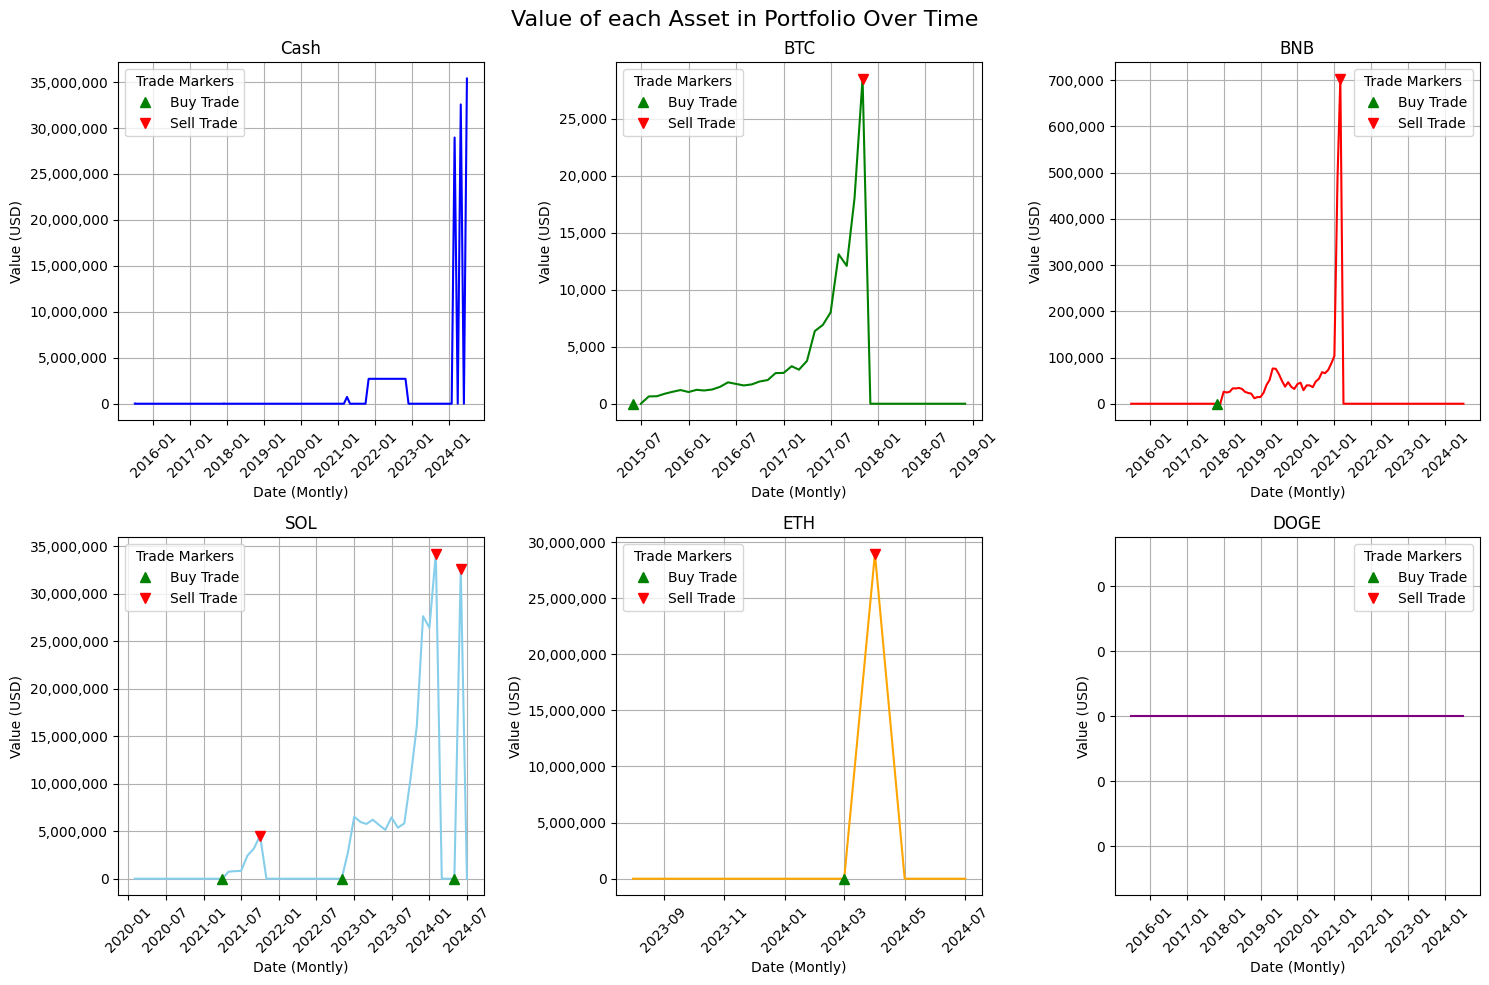

In [823]:
# Get the list of columns excluding the 'Date' column
columns = [col for col in convertedPortfolioHistory.columns if col != "Date"]

convertedPortfolioHistory["Date"] = pd.to_datetime(convertedPortfolioHistory["Date"])

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the 2x3 array of axes for easy iteration
axs = axs.flatten()

# Plot each column in a separate subplot with a different color
for i, column in enumerate(columns):
  match column:
    case "BTC":
      non_zero_data = convertedPortfolioHistory[
        ~(convertedPortfolioHistory["Date"] >= "2019-01-01")
      ]
    case "SOL":
      non_zero_data = convertedPortfolioHistory[
        ~(
          (convertedPortfolioHistory["Date"] >= START_DATE)
          & (convertedPortfolioHistory["Date"] <= "2020-01-01")
        )
      ]
    case "ETH":
      non_zero_data = convertedPortfolioHistory[
        ~(
          (convertedPortfolioHistory["Date"] >= START_DATE)
          & (convertedPortfolioHistory["Date"] <= "2023-07-01")
        )
      ]
    case default:
      non_zero_data = convertedPortfolioHistory

  axs[i].plot(
    non_zero_data["Date"],
    non_zero_data[column],
    color=CRYPTO_COLORS[column],
  )
  axs[i].set_title(column)
  axs[i].set_xlabel("Date (Montly)")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

  # Use ScalarFormatter to avoid scientific notation
  formatter = ScalarFormatter(useOffset=False)
  formatter.set_scientific(False)
  axs[i].yaxis.set_major_formatter(formatter)
  # Add commas to y-axis values
  axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

  # Add markers for trades
  for trade in TRADES:
    tradeType = trade["Type"]
    tradeCommodity = trade["commodity"]
    tradeDate = pd.to_datetime(trade["Date"])

    if column != tradeCommodity:
      continue

    if tradeType == "buy":
      marker = "^"
      color = "green"
    elif tradeType == "sell":
      marker = "v"
      color = "red"

    # Get the previous month for the marker
    previous_month_date = pd.Timestamp(tradeDate) - pd.DateOffset(months=1)
    tradeDate = previous_month_date
    if tradeType == "buy":
      y_value = 0
    elif tradeType == "sell":
      # Retrieve the value for the previous month
      y_value = convertedPortfolioHistory.loc[
        convertedPortfolioHistory["Date"] == previous_month_date, column
      ].values[0]

    axs[i].plot(tradeDate, y_value, marker=marker, color=color, markersize=7)

  # Add the marker legend
  axs[i].legend(handles=[GREEN_TRIANGLE, RED_TRIANGLE], title="Trade Markers")

fig.suptitle("Value of each Asset in Portfolio Over Time", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 3.7 When Trades were Made Relative to Crypto Stock Prices


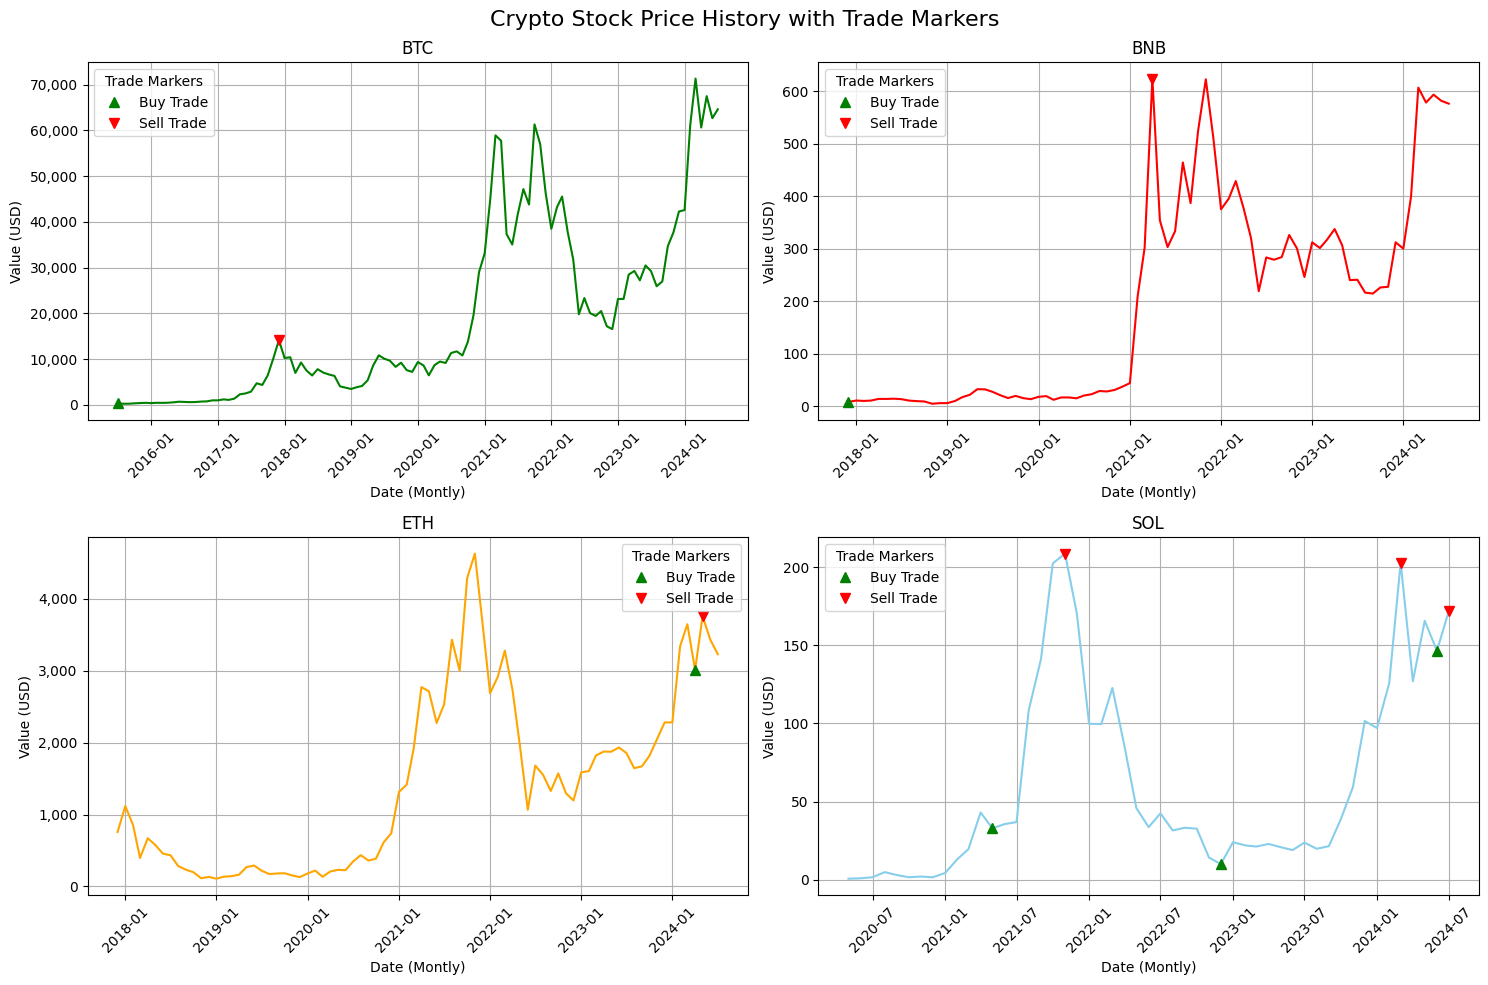

In [824]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the 2x2 array of axes for easy iteration
axs = axs.flatten()

# Remove the DOGE df since we maed no trades with it
if "DOGE" in crypto_dataframes:
  crypto_dataframes.pop("DOGE")

# Plot each column in a separate subplot with a different color
for i, (crypto, df) in enumerate(crypto_dataframes.items()):
  df["Date"] = pd.to_datetime(df["Date"])

  axs[i].plot(
    df["Date"],
    df["Close"],
    color=CRYPTO_COLORS[crypto],
  )
  axs[i].set_title(f"{crypto}")
  axs[i].set_xlabel("Date (Montly)")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

  # Use ScalarFormatter to avoid scientific notation
  formatter = ScalarFormatter(useOffset=False)
  formatter.set_scientific(False)
  axs[i].yaxis.set_major_formatter(formatter)
  # Add commas to y-axis values
  axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

  # Add markers for trades
  for trade in TRADES:
    tradeType = trade["Type"]
    tradeCommodity = trade["commodity"]
    tradeDate = pd.to_datetime(trade["Date"])

    if crypto != tradeCommodity:
      continue

    if tradeType == "buy":
      marker = "^"
      color = "green"
    elif tradeType == "sell":
      marker = "v"
      color = "red"

    # Get y value for the marker
    y_value = df.loc[df["Date"] == tradeDate, "Close"].values[0]
    # Plot the marker
    axs[i].plot(tradeDate, y_value, marker=marker, color=color, markersize=7)

  # Add the marker legend
  axs[i].legend(handles=[GREEN_TRIANGLE, RED_TRIANGLE], title="Trade Markers")

fig.suptitle(
  "Crypto Stock Price History with Trade Markers",
  fontsize=16,
)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 3.8 Calculate Overall Gains

b. Calculate your overall gains over the investment period.

- All final amounts are to be calculated to their value at the end of July 2024.


In [831]:
print(f"Starting Balance: ${STARTING_BALANCE:,.2f}")
print(f"Final Balance: ${FINAL_BALANCE:,.2f}\n")

# Account for Inflation
STARTING_VALUE = 1000
final_value_pre_inflation = 10_000

TOTAL_CPI_2015_07 = 127.3  # Consumer Price Index for July 2015
TOTAL_CPI_2024_06 = (
  161.4  # Consumer Price Index for June 2024 (Didn't have July 2024 data)
)

INFLATION_FACTOR = TOTAL_CPI_2015_07 / TOTAL_CPI_2024_06

finalBalancePostInflation = FINAL_BALANCE * INFLATION_FACTOR

print(
  f"Final balance post-inflation (Relative to July 2015): ${finalBalancePostInflation:,.2f}"
)

# Calculate the percent gain (relative to July 2015)
percent_gain = ((finalBalancePostInflation - STARTING_BALANCE) / STARTING_BALANCE) * 100
print(f"Percent gain (Relative to July 2015): {percent_gain:,.2f}%")

Starting Balance: $793.02
Final Balance: $35,378,663.46

Final balance post-inflation (Relative to July 2015): $27,903,989.21
Percent gain (Relative to July 2015): 3,518,593.04%
